# Predicting Credit Card Defaults

#### _Jeremy Locatelli, Erik Ring-Walters, Andrea Cano_
***

# Introduction
* This markdown is going to explore the data of a credit card csv from UCI's database. The data provides details on a subjects spousal information, age, education, sex, balance, payments, and whether they have defaulted. Using these categories we hope to predict what influences an individual to default. Using multiple algorithms to find the best predictors we will try and visualize the accuracy

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix,roc_curve


In [2]:
# EDIT FILE PATH HERE
filename = 'default_cc_train.csv'

In [3]:
dat = pd.read_csv(filename)
dat.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

***
## Data Exploration

* To start we generally explore the data to find what initial observations would be, spot any abnormalities and fix any possible nulls or odd values within the dataset.

In [4]:
sns.set_style("whitegrid");

* The countplot below shows the initial amount of subjects in the dataset who have or have not defaulted. According to the plot, Defaulting, which is represented by the number 1, is not an overwhelming occurrence. 

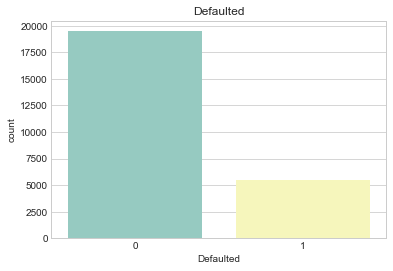

In [5]:
sns.countplot("default.payment.next.month", data=dat,palette="Set3")
plt.title("Defaulted")
plt.xlabel("Defaulted");

* This next countplot, also shows those who have defaulted but now it is separated by sex. Sex is represented with 1 being Male and the color Green and 2 being Female and the color yellow. It doesn't seem that sex has an overpowering influence but it is interesting to see the difference in the amount of females vs males. From the graph, not only does it show that females were most likely not to default it also shows that they defaulted more than males. Is this because there are more females in this set or could it be because of something else?

Number of Males:  9891
Number of Females:  15109


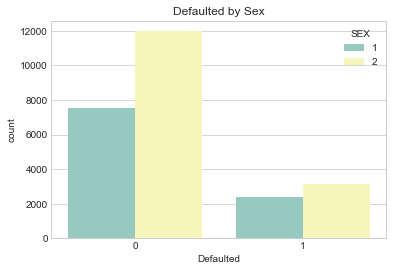

In [6]:
sns.countplot("default.payment.next.month", data=dat, hue="SEX",palette="Set3")
plt.title("Defaulted by Sex")
plt.xlabel("Defaulted");

print("Number of Males: ", sum(dat["SEX"]==1))
print("Number of Females: ", sum(dat["SEX"]==2))

* The next option to look at is AGE. The ages are widely spread throughout the data, but according to the density curve we have a lot of ages peaking at the late twenties. Most likely due to college fees or recent graduates, that most credit card companies target. 

C:\Users\Andrea\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


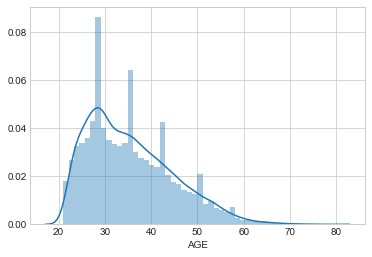

In [7]:
sns.distplot(dat.AGE);

* So because AGE has a distinctive area of population, a violin plot will show just how many have defaulted in an age range. And from the plot, it is noticeably wider between the ages of 20-30. However, each violin has a similar shape and median when it comes to defaulting. The only major difference is the fact that around age 35 there is a higher chance to default. 

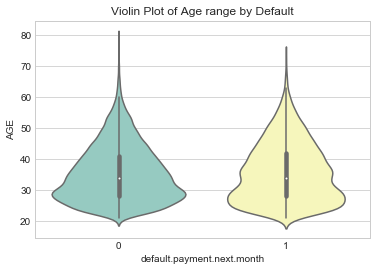

In [8]:
sns.violinplot("default.payment.next.month","AGE", data=dat, palette="Set3")
plt.title("Violin Plot of Age range by Default");

* Marriage is another category to look at. According to the dataset; 1 stands for married, 2 stands for single, and 3 stands for others. However, 0 is also included in this barplot. But because there is no definition for this value it is assumed to be a placeholder. This is something that should be dropped and dealt with in the preprocessing. Because the 0 values will be dropped from further explorations, the rest of this description of the graph will take it out of consideration.

* The barplot shows that around 26% of married males defaulted where as 22% of married females defaulted. The black lines show a margin of error which is understandable as to why it is so long in the "others" category for both males and females. 

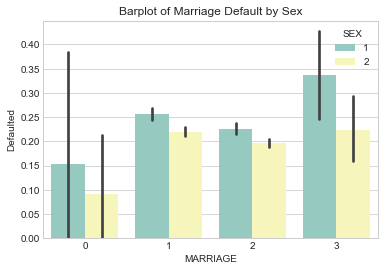

In [9]:
sns.barplot(x="MARRIAGE",y="default.payment.next.month", hue="SEX", data=dat, palette="Set3")
plt.title("Barplot of Marriage Default by Sex")
plt.ylabel("Defaulted");

* Next is defaulting based off of education. According to the dataset, 1 means Graduate School, 2 means University, 3 means Highschool, and 0,4,5,6 are all categorized as others. This is another instance where preprocessing comes into play. So instead of removing the categories they will be merged into a single category known as other.

* With the preprocessing in mind, another look at the graph shows that those who are in University are the most and least likely to default on payments. This is interesting since for each level of education it is a low chance for defaulting compared to not defaulting. 

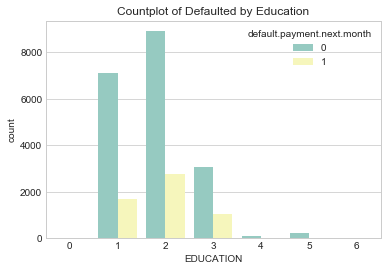

In [10]:
edu = sns.countplot(x="EDUCATION", hue="default.payment.next.month", data=dat, palette="Set3")
plt.title("Countplot of Defaulted by Education");

* Last plot to look at is a boxplot for the first Pay period in September 2005, The pay history is categorized where -2 is no consumption, -1 is paid in full, 0 is the use of revolving credit, and 1-8 are payments delayed by that number of months. 

* So looking at this plot we notice that Defaulting was a popular occurrence after a payment was delayed after 1 month. 


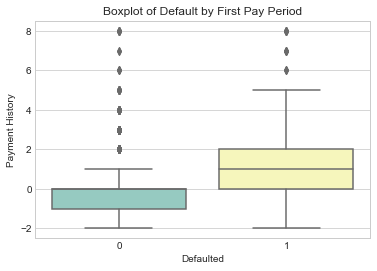

In [11]:
sns.boxplot("default.payment.next.month", "PAY_0",data = dat, palette = "Set3")
plt.title("Boxplot of Default by First Pay Period")
plt.xlabel("Defaulted")
plt.ylabel("Payment History");

## Preprocessing

* As discussed above, some preprocessing needed was in the Marriage and Education tabs. To correct these inconsistencies we used two different techniques. 

* First for the Marriage section, the 0 column was removed entirely because it did not represent any information in the dataset. 

* Then for Education, since columns 0,4,5,6 all stood for "other", replace was used to combine all those columns into a single "other" option which was placed in the number 4 column.


In [12]:
#Getting rid of 0's in Marriage
dat = dat[dat.MARRIAGE != 0]


#getting rid of 0,5,6 in Education
for i in [0,5,6]:
    dat.EDUCATION.replace(i,4)
        

In [13]:
#Creating arrays of Data being used and scaled
datCat = pd.DataFrame(dat[["SEX","EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5"]])
datNum = pd.DataFrame(dat[["LIMIT_BAL","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1","PAY_AMT2","PAY_AMT3", "PAY_AMT4", "PAY_AMT5","PAY_AMT6"]])
datUse = dat[["SEX","EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5","LIMIT_BAL","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1","PAY_AMT2","PAY_AMT3", "PAY_AMT4", "PAY_AMT5","PAY_AMT6"]]

#Column Name Arrays
catName = ["SEX","EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5"]
numName= ["LIMIT_BAL","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1","PAY_AMT2","PAY_AMT3", "PAY_AMT4", "PAY_AMT5","PAY_AMT6"]

* Another important factor is to scale the data, later on in the data there will be a comparison between scaled and unscaled data to emphasize the necessity. 

In [14]:
#Scaling the data
class DataSelect(BaseEstimator,TransformerMixin):
    def __init__(self, colNames):
        self.colNames = colNames
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return  X[self.colNames]


#Getting rid of NA's for numerical data
pipeNumeric = Pipeline([
 ("select_cols", DataSelect(numName)),
 ("z-scaling", StandardScaler())
 ])
pipNum = pipeNumeric.fit_transform(datNum)

#Need to deal with strings in categorical before putting in piepline so use get_dummies

class DumCat(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Adding dummies when needed"""
    def fit(self, X,y=None):
        self.dummyDat = pd.get_dummies(X) #Creating dataFrame to run the function
        return self
    def transform(self,X):
        return self.dummyDat #return the dummyDat that has the new columns


#to access, need to Class.fit_transform(dataWantChanged)


#Getting rid of NA's for categorical data
pipeCategory = Pipeline([
 ("select_cols", DataSelect(catName)),
 ("get_dummies", DumCat()),
 ])
pipCat = pipeCategory.fit_transform(datCat)


#Now that the data is processed, need to join the Numerical and Categorical 

full_pipeline = FeatureUnion(transformer_list=[
         ('cat_data',pipeCategory),
        ('num_data',pipeNumeric)
        ])
united = full_pipeline.fit_transform(datUse)

***
## Gradient Boosting Classifier

* Gradient boosting will select the best features in our datasets. This helps to see which features have the most impact on whether or not a person will default. 
* From the results given, it seems that PAY_0, which is the first payment in the set, has the largest influence on the results of defaulting. Meaning, that if a person doesn't pay their first month's bill amount, they are more likely to default. 

In [15]:
X = united
y  = dat.iloc[:,24] #default.payment.next.month

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

grad_clf = GradientBoostingClassifier(n_estimators=150,learning_rate=0.1,max_depth=2,loss="deviance")
grad_clf.fit(X_train,y_train)
grad_predicts = grad_clf.predict(X_test)

grad_acc = accuracy_score(grad_predicts,y_test)
grad_mse = mean_squared_error(grad_predicts,y_test)

print("The MSE for Gradient Boosting is : ", grad_mse)
print("The accuracy of Gradient Boosted Classification is: ", grad_acc)

The MSE for Gradient Boosting is :  0.18360655737704917
The accuracy of Gradient Boosted Classification is:  0.8163934426229508


In [16]:
tn, fp, fn, tp = confusion_matrix(y_test,grad_predicts).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
print("Precision is: ",tp /(tp+fp))
print("Recall is: ",tp/(tp+fn))

True Negatives:  6091
False Positives:  298
False Negatives:  1214
True Positives:  632
Precision is:  0.6795698924731183
Recall is:  0.3423618634886241


In [17]:
best_features = grad_clf.feature_importances_
best = np.vstack((datUse.columns, best_features))
best_columns = pd.DataFrame(data=best.transpose())
sorted_best_features = best_columns.sort_values(by=[1], ascending=False)
sorted_best_features.head(5)

,0,1
3,PAY_0,0.123705
9,BILL_AMT1,0.114598
8,LIMIT_BAL,0.0900316
14,BILL_AMT6,0.0799367
10,BILL_AMT2,0.0597789


***
## Base Classifiers
* ### SVM without Scaling
* To begin explaining the Support Vector Machine, the first step is to split the data into training and test sets along with separating are target from our training data. Because our outcome is to predict whether someone will default or not, the target will be "default.payment.next.month" and our X will be everything but that column. 

* Using the SVC function imported though sklearn.svm, on the whole dataset without moderation, the accuracy is approximately 78% this is the  baseline of what the future algorithms should surpass.

In [ ]:
X = dat.loc[:, dat.columns != "default.payment.next.month"]
y  = dat.iloc[:,24]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)


svm = SVC()

# Training and predictions SVC
svm.fit(X_train,y_train)
predicts = svm.predict(X_test)
accuracy = accuracy_score(y_test,predicts)
print("The accuracy of our Support Vector Classifier is: " + str(accuracy))

#next Scale data and rerun

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,predicts).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
print("Precision is: ",tp /(tp+fp))
print("Recall is: ",tp/(tp+fn))

* ### SVM with Scaled Data
* This SVM is using the result from the feature Union of the scaled data. With the data scaled, the accuracy improves into the 80+ range, which is not a large difference but it is an improvement and step in the right direction when moving forward through the other algorithms.
* From now on the data used will be the fully preprocessed and will work towards finding the best features to improve accuracy.

In [ ]:
X = united
y  = dat.iloc[:,24]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)


svm = SVC()

# Training and predictions SVC
svm.fit(X_train,y_train)
predicts = svm.predict(X_test)
accuracy = accuracy_score(y_test,predicts)
print("The accuracy of our Support Vector Classifier is: " + str(accuracy))

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,predicts).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
print("Precision is: ",tp /(tp+fp))
print("Recall is: ",tp/(tp+fn))

***
## Dimensionality Reduction

* Because running the SVM's took a large amount of time, reducing the features can save runtime without sacrificing the accuracy or could possibly improve it. 
* Principle Component Analysis will show a reasonable number of dimensions needed for the data to be represented. According to the results, 14 dimensions out of the possible 21 can be used and still represent approximately 95% of the data.

In [ ]:
# PCA to reduce dimensions 
pca = PCA(n_components=0.99)
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(str(d) + " dimensions explain 95% of our data.")
d = np.argmax(cumsum >= 0.99) + 1
print(str(d) + " dimensions explain 99% of our data.")

# this is the reduced dimension set, use this to train all our models 
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

***
## Classifiers Continued
* ### SVM Again
* Let's run the SVM again but this time with the PCA reduced dimensions.
* With the reduced dimensions, the classifier's accuracy stayed within the 82% range.

In [ ]:
svm.fit(X_train_reduced,y_train)
predicts = svm.predict(X_test_reduced)
accuracy = accuracy_score(y_test,predicts)
print("The accuracy of our Support Vector Classifier is: " + str(accuracy))

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,predicts).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
print("Precision is: ",tp /(tp+fp))
print("Recall is: ",tp/(tp+fn))

* ### Logistic Regression
* Let's take a look at how the PCA effects logistic regression.
* Below is the classic logistic regression based on the scaled data but without the use of PCA. The accuracy is above average at ~81%

In [ ]:
# Logistic Regression
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
log_predicts = log_clf.predict(X_test)

log_acc = accuracy_score(log_predicts,y_test)
print("The accuracy of Logistic Regression is: ", log_acc)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,log_predicts).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
print("Precision is: ",tp /(tp+fp))
print("Recall is: ",tp/(tp+fn))

* However, with the use of PCA, the accuracy changed by approximately .003. And this is excluding 4 dimensions that did not greatly impact the data.
* The confusion matrix shows the slight differences where the predictions were different from the original logistic function.

In [ ]:
log_clf = LogisticRegression()
log_clf.fit(X_train_reduced, y_train)
log_predicts_reduced = log_clf.predict(X_test_reduced)

log_acc = accuracy_score(log_predicts_reduced,y_test)
print("The accuracy of Logistic Regression is: ", log_acc)

* The ROC curve shows the quality of the output by using cross validation

In [ ]:
log_y_score = log_clf.decision_function(X_test_reduced)
fpr, tpr, _ = roc_curve(y_test, log_y_score)
plt.plot(fpr,tpr,lw=2,color="#53c681")
plt.title("ROC curve of Logistic Regression");

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,log_predicts_reduced).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
print("Precision is: ",tp /(tp+fp))
print("Recall is: ",tp/(tp+fn))


* ### Random Forest Classifier
* Random forest picks the best features from a random subset of features by using an ensemble of decision trees.
* Again using the PCA reduced dimensions we test a random forest classifier to see a similar accuracy of ~80%.

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=50,random_state=1)
rf_clf.fit(X_train_reduced, y_train)
rf_predicts = rf_clf.predict(X_test_reduced)

rf_acc = accuracy_score(rf_predicts,y_test)
print("The accuracy of Random Forest Classification is: ", rf_acc)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,rf_predicts).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
print("Precision is: ",tp /(tp+fp))
print("Recall is: ",tp/(tp+fn))

***
## Voting Classifier
* Next is a voting classifier consisting of logistic regression, random forest, and the support vector classifier. Using hard voting, this classifier uses and compares the different algorithms in order to get the best accuracy.
* However, from the results, SVC has a higher accuracy of predicting whether someone will default than the voting classifier; leading up to the conclusion of the results collected.

In [ ]:
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm)],
voting='hard')


voting_clf.fit(X_train, y_train)
for clf in (log_clf, rf_clf, svm, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

***
## Conclusion

Given credit card information, the report contains exploration of the data as a whole, and an attempt to make predictions on whether a customer will default. The data consists of features such as age, sex education level, marital status, payments, bills. According to gradient boosting feature selection, a payment due in the first month (PAY_0) is a large factor in predicting the output on whether a credit card holder will default. The PCA feature reduction decreased our number of features even more from 21 to 14 while still maintaining 95% of the data. The reduced data ran through various machine learning algorithms such as support vector classifiers, logistic regression, and gradient boosting to gather and compare the resulting prediction accuracy scores. The highest accuracy recorded was around 0.82 with support vector classifier with gradient boosting yielded a similar accuracy.
